# CLT Demonstration

This is a demonstration of how the central limit theorem (CLT) works. Remember that we're less interested in the distribution of the underlying data and more interested in the distribution of the means. Specifically, we expect the distribution of the _sample means_ to be normally distributed. We'll see why shortly.

To begin with we'll run a skinny version of the code we use in the main analysis.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Name of the file in directory. Could also be directly downloaded in Python
data = "2020-public-service-employee-survey-open-dataset-ensemble-de-donnees-ouvertes-du-sondage-aupres-.csv"

# Load Data Set
pse = pd.read_csv(data, encoding = "ANSI")

# PSE File
# LEVEL1ID = 8   - Statistics Canada
# LEVEL2ID = 203 - Economic Statistics Field
# LEVEL3ID = 306 - Economy-wide Statistics Branch
# LEVEL4ID = 417 - Producer Prices Division

public_service = pse[(pse.LEVEL1ID == 0) & (pse.LEVEL2ID == 0) & 
                     (pse.LEVEL3ID == 0) & (pse.LEVEL4ID == 0) & 
                     (pse.BYCOND == " ") & (pse.SURVEYR == 2020)]
ppd = pse[(pse.LEVEL1ID == 8) & (pse.LEVEL2ID == 203) &
          (pse.LEVEL3ID == 306) & (pse.LEVEL4ID == 417)]

def get_counts(df, q):
    """Takes a data frame and a question and returns the number of positive
    and negative responses for that question as well as the total.
    
    df -- DataFrame to get counts from
    q  -- Question to get counts from"""
    # Condition to deal with Yes/No answers. Note, one implication of this fix
    # is that 'Agree' is mapped to positive which should be kept in mind when
    # reading questions like Q53
    ans_count = int(df[df.QUESTION == q].ANSCOUNT)
    
    if q in ["Q28", "Q53", "Q85", "Q87", "Q88", "Q89", "Q90"]:
        no_pos = int(((df[df.QUESTION == q].AGREE / 100) * 
                      ans_count).round())
        no_neg = ans_count - no_pos
    else:
        no_pos = int(((df[df.QUESTION == q].MOST_POSITIVE_OR_LEAST_NEGATIVE / 100) * 
                      ans_count).round())
        no_neg = int(((df[df.QUESTION == q].MOST_NEGATIVE_OR_LEAST_POSITIVE / 100) * 
                      ans_count).round())
    
    return (no_pos, no_neg, no_pos + no_neg)

def make_sample(df, q, rm_ppd = False):
    """ Takes the positive/negative proportions from a given data frame and 
    turns them into an array.
    
    df -- DataFrame to take proportions from
    q  -- Question to take proportions from
    rm_ppd -- Boolean for when sample is superset of PPD, default False"""
    
    no_pos, no_neg, count = get_counts(df, q)
        
    if rm_ppd:
        ppd_pos, ppd_neg, ppd_n = get_counts(ppd, q)
        no_pos -= ppd_pos
        no_neg -= ppd_neg
        count -= ppd_n
    
    sample = np.zeros(count)
    sample[:no_pos] = 1
    
    return sample

We're testing the means between the "positive/least negative" responses which is equivalent to testing the proportion of positive responses. If we require the observations (which we do not have but can derive) to be normally distributed, we shouldn't even need to look at the data to know this won't be true. Fortunately the computer is doing all the work so we can check it anyway. Let's use Question 28 as an example seeing as it's one that came back as significant.

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

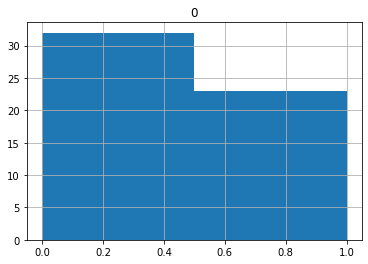

In [2]:
pd.DataFrame(make_sample(ppd, "Q28")).hist(bins = 2)

There are only two states! 1 or 0. Because I'm doing the default plot Python lists values along the bottom (there are only two bins so values less than 0.5 fall in one, which in this case are all 0, and values above 0.5 fall in the other bin. The presence of a value on the axis should not be taken as there being an observation at that actual value).

As a quick aside, setting the bins matters in terms of how readable these charts are. Here's what it looks like for the default settings:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

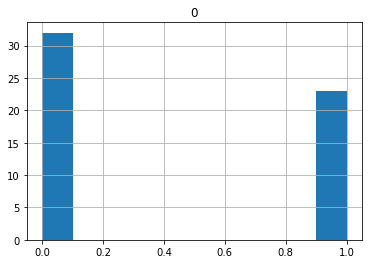

In [3]:
pd.DataFrame(make_sample(ppd, "Q28")).hist()

Here the gaps are instructive. As the number of samples grows the gaps will shrink, but occasionally the histogram method will wind up bunching a lot of observations into one bin. There's a tradeoff between making nice looking plots and keeping consistent axes and in this case I have opted to keep them consistent for comparsion. The key here will be to look at the overall shape and just accept that gaps will occasionally pop up and wind up in the adjacent bins.

Before looking at plots, let's look at the average.

In [4]:
make_sample(ppd, "Q28").mean()

0.41818181818181815

About 0.418. Based on this number already we should be worried about arguments that say that we can't use a continuous distribution when working with dichotomous variables because our mean doesn't resemble any of our observations. This is a bit of a silly remark but it's intended to highlight the importance of being clear that we are making statements about the mean which has a different distribution (as we will see shortly).

In order to illustrate the CLT we'll take this question and sample it with replacement (this means that each time we'll draw a sample of the same size as the survey, but it will be a sample randomly drawn and that it is possible for an observation to be drawn twice. If you've done some kind of bootstrap, you've likely done something like this or at least had the computer do it for you).

For an example we'll see what the mean of one of these samples is like.

In [5]:
pd.DataFrame(make_sample(ppd, "Q28")).sample(frac = 1, replace = True).mean()[0]

0.38181818181818183

About 0.381 which is around 0.03 off from our mean. This shouldn't be a cause for alarm because it would be extraordinary for the means to be identical (it would mean that with replacement we got the exact same sample). The CLT tells us that as we calculate more means from these samples, the distribution of these samples will resemble the normal distribution.

To put it another way, we cannot afford to wait for 1000 more PSES to be conducted and so we simulate them (in fact, we specifically simulate the PPD component for this one question) to see what it would look like.

In [21]:
means_10 = []
means_20 = []
means_50 = []
means_100 = []
means_1000 = []
means_10000 = []
for _ in range(10):
    means_10.append(pd.DataFrame(make_sample(ppd, "Q28")).sample(frac = 1, replace = True).mean())
for _ in range(20):
    means_20.append(pd.DataFrame(make_sample(ppd, "Q28")).sample(frac = 1, replace = True).mean())
for _ in range(50):
    means_50.append(pd.DataFrame(make_sample(ppd, "Q28")).sample(frac = 1, replace = True).mean())
for _ in range(100):
    means_100.append(pd.DataFrame(make_sample(ppd, "Q28")).sample(frac = 1, replace = True).mean())
for _ in range(1000):
    means_1000.append(pd.DataFrame(make_sample(ppd, "Q28")).sample(frac = 1, replace = True).mean())
for _ in range(10000):
    means_10000.append(pd.DataFrame(make_sample(ppd, "Q28")).sample(frac = 1, replace = True).mean())

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

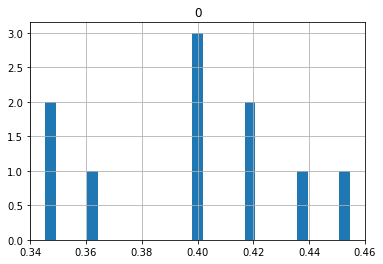

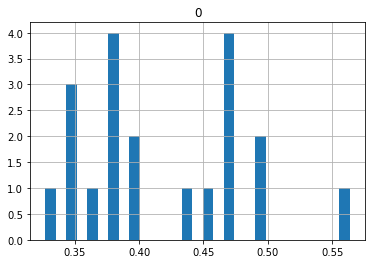

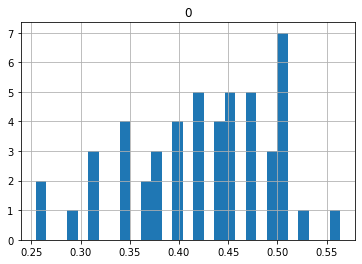

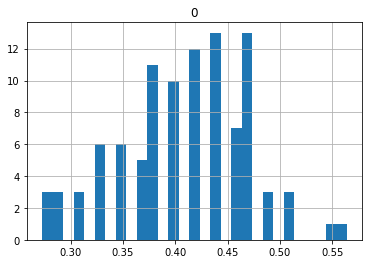

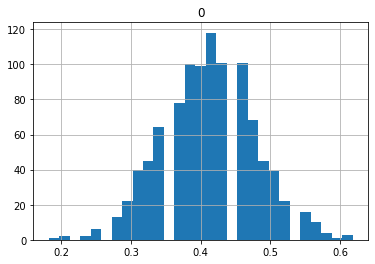

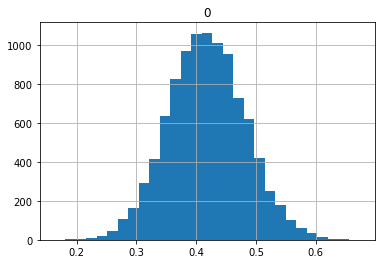

In [23]:
bn = 29
pd.DataFrame(means_10).hist(bins = bn)
pd.DataFrame(means_20).hist(bins = bn)    
pd.DataFrame(means_50).hist(bins = bn)
pd.DataFrame(means_100).hist(bins = bn)
pd.DataFrame(means_1000).hist(bins = bn)
pd.DataFrame(means_10000).hist(bins = bn)

From 10 or 20 samples it's tricky to discern any clear pattern. At 50 and 100 samples the shape starts slowly emerging, but the normal distribution is most clear after 1,000 and 10,000 samples, just as the CLT would have us believe (increasing the number would get even closer, but it would be time consuming to run).

It is easy to misunderstand some concepts here and so it is helpful to clarify a few steps. The mean is calculated from a different sample each time with the same number of observations (in this case 55). We are collecting the number of means and as the number of means goes up it takes on the shape of the normal distribution. The CLT does _not_ say that as n increases the data becomes normal, and it is not a comment on the number of observations needed in the sample in order to count as 'large'.

It seems fair to say that the more 'non-normal' a population is the more observations we would need in the sample to approximate normality. The best I've been able to find here is a rule of thumb of about 20-30. To quote Wooldridge's undergraduate textbook "Unfortunately, we are necessarily limited in what we can say about how 'large' a sample size is needed for asymptotic analysis to be approximate; this depednds on the underlying population distribution. But large sample approximations have been known to work well for sample sizes as small as n = 20."

For further illustration let's consider Q18h, which showed a significant difference but had a small number of responses (39). We'll run the same simulation with the smaller sample producing the estimates of the mean.

In [25]:
means_10 = []
means_20 = []
means_50 = []
means_100 = []
means_1000 = []
means_10000 = []
for _ in range(10):
    means_10.append(pd.DataFrame(make_sample(ppd, "Q18h")).sample(frac = 1, replace = True).mean())
for _ in range(20):
    means_20.append(pd.DataFrame(make_sample(ppd, "Q18h")).sample(frac = 1, replace = True).mean())
for _ in range(50):
    means_50.append(pd.DataFrame(make_sample(ppd, "Q18h")).sample(frac = 1, replace = True).mean())
for _ in range(100):
    means_100.append(pd.DataFrame(make_sample(ppd, "Q18h")).sample(frac = 1, replace = True).mean())
for _ in range(1000):
    means_1000.append(pd.DataFrame(make_sample(ppd, "Q18h")).sample(frac = 1, replace = True).mean())
for _ in range(10000):
    means_10000.append(pd.DataFrame(make_sample(ppd, "Q18h")).sample(frac = 1, replace = True).mean())

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

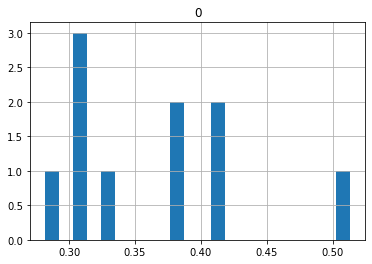

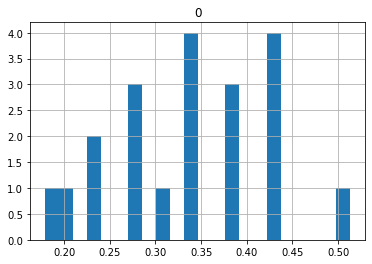

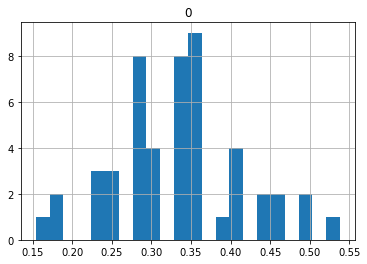

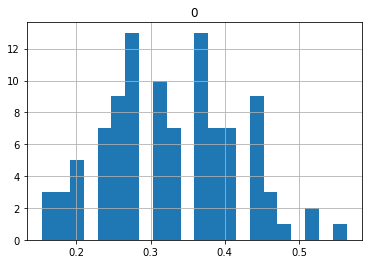

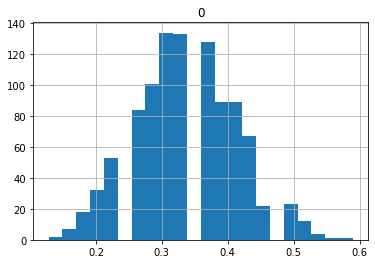

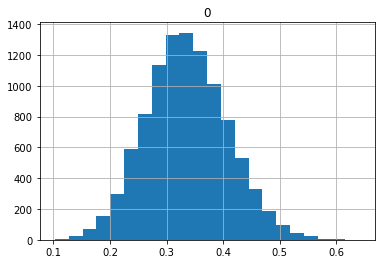

In [33]:
bn = 22
pd.DataFrame(means_10).hist(bins = bn)
pd.DataFrame(means_20).hist(bins = bn)    
pd.DataFrame(means_50).hist(bins = bn)
pd.DataFrame(means_100).hist(bins = bn)
pd.DataFrame(means_1000).hist(bins = bn)
pd.DataFrame(means_10000).hist(bins = bn)

In order to try and minimize the gaps these plots use a smaller number of bins but the point is still the same even despite the relative coarseness of the plot. The distribution of means is normal, centered around the mean that we get from the PSES.

These examples should illustrate what it means to make statements about the mean. A higher response rate for the survey will not change the distribution of the responses, but because we are making a statment about the mean of those responses relative to another group, we care about its distribution. This kind of test can be replicated with any given distribution in your favourite statistical program and as the number of means gets larger the 